In [9]:
from brian2 import *
import matplotlib.pyplot as plt
import matplotlib.cm

# Dendritic Spines


### notes on the cable equation

Brian is really trying to find the solution to this equation at each compartment

\begin{equation}
\frac{r_m}{r_l}  \frac{\partial^2 V}{\partial x^2} = c_m r_m \frac{\partial V}{\partial t} + V
\end{equation}

or rewritten,

\begin{equation}
\lambda^2  \frac{\partial^2 V}{\partial x^2} = \tau \frac{\partial V}{\partial t} + V
\end{equation}

where $\lambda$ is the space constant and $\tau$ is the time constant.

### on $R_i$
Remember that $R_T$ (R total) defined by Yuste is not the internal resistivity R_i which Brian takes as a parameter.
\begin{equation}
R_T [\Omega] = R_i \frac{L}{\pi a^2}
\end{equation} 

Therefore to get $R_i [\omega \text{cm}]$, we need to know the dimensions of the spine.

\begin{equation}
R_i = R_T \frac{\pi a^2}{L}
\end{equation}

R_i is typically on the order of 100 $[\Omega \text{cm}]$. For the measured value in Cornejo, 100 $M\Omega$, and assuming spine dimensions are on the order $~10^-4 cm (0.1 um)$ for the radius and the length, this gives us an $R_i ~ 10^4$ ohm cm which is two orders of magnitude higher than expected.

## Simulation Code

In [52]:
def default_params(**kwargs):
    p = {
    # morph
    'd_spine_head' : 1.*um, #um
    'l_spine_neck' : 0.66 *um, # um
    'd_spine_neck' : 0.2 *um, # um
    'd_soma' : 20 *um , # um
    'd_dendrite': 3 *um, # um
    'l_dendrite' : 300 *um, # um
    'n_neck' : 5,
    'n_dend' : 10,
    
    # sim
    'VK' : -70. * mV,
    'V_r' : -70. * mV, 
    'gl' : 0.3*msiemens/cm**2,
    'g_AMPA' : 2.08 * nsiemens/cm**2,
    'gK' : 1*siemens/meter**2,
    'El' : -70*mV,
    'E_AMPA' : 0 *mV,
    'Cm' :1*uF/cm**2, # specific membrane capacitance
    'Ri': 100*ohm*cm, # intracellular resistivity
    'Ri_neck' : 1e4*ohm*cm,
    'thres' : 'v > 0*mV',
    'ref' : 'v > -10*mV',
    'I_stim' : 10 *pA
    }
    
    p.update(kwargs)
    
    return p

In [53]:
def g12(a1, a2, r1, r2, L1, L2):
    """the conductance between compartments 2->1 (directional)

    Args:
        a1 (float): radius of compartment 1
        a2 (int/float): radius of compartment 2
        r1 (int/float): intracellular resistivity of compartment 1 [ohm*cm]
        r2 (int/float): intracellular resistivity of compartment 2 [ohm*cm]
        L1 (int/float): length of compartment 1 [m]
        L2 (int/float): length of compartment 2 [m]

    Returns:
        float : g_ij conductance of the flow from compartment j to compartment i
    """    
    num = 2* pi * a1**2 * a2**2
    den = a2**2 * r1 * L1 + a1**2 * r2 * L2
    return num/den

In [54]:
def run_sim(params):
    start_scope()

    # Set the default time step
    defaultclock.dt = 0.01*ms

    # Simulation Parameters
    VK = params['VK']
    V_r = params['V_r']
    thres = params['thres']
    ref = params['ref']
    gl = params['gl']
    gK = params['gK']
    El = params['El']
    E_AMPA = params['E_AMPA']
    Cm = params['Cm']
    Ri = params['Ri']
    Ri_neck = params['Ri_neck']
    I_stim = params['I_stim']
    
    # Morphology Parameters
    d_spine_head = params['d_spine_head'] # um
    l_spine_neck = params['l_spine_neck'] # um
    d_spine_neck = params['d_spine_neck'] # um
    d_soma = params['d_soma'] # um
    d_dendrite = params['d_dendrite'] # um
    l_dendrite = params['l_dendrite'] # um
    n_neck = params['n_neck']
    n_dend = params['n_dend']

    # -----------------------------
    # Model Equations
    # -----------------------------

    eqs = '''
    Im = gl * (El - v) : amp/meter**2
    I_long = gDN * (v_neck - v) : amp (point current)
    gDN : siemens
    v_neck : volt
    I : amp (point current)
    '''

    eqs_neck = '''
    Im = gl * (El - v) + gK * (VK - v): amp/meter**2
    I_long = gND * (v_dend - v) + gNH * (v_head - v) : amp (point current)
    gND : siemens
    gNH : siemens
    v_dend : volt
    v_head : volt
    I : amp (point current)
    '''

    eqs_head = '''
    Im = gl * (El - v) + g_AMPA * (E_AMPA - v): amp/meter**2
    I_long = gHN * (v_neck - v) : amp (point current)
    g_AMPA : siemens/meter**2
    gHN : siemens
    v_neck : volt
    I : amp (point current)
    '''

    # Create a morphology
    soma_morph = Cylinder(diameter = d_soma, length = d_soma)
    soma_morph.dendrite = Cylinder(diameter = d_dendrite, length = l_dendrite, n = n_dend)
    neck_morph = Cylinder(diameter = d_spine_neck, length = l_spine_neck, n = n_neck)
    head_morph = Cylinder(diameter = d_spine_head, length = d_soma)

    # Generate the neurons
    soma = SpatialNeuron(morphology=soma_morph, model=eqs, Cm=Cm, Ri=Ri, threshold = thres, threshold_location=0, refractory = ref)
    neck = SpatialNeuron(morphology=neck_morph, model=eqs_neck, Cm=Cm, Ri=params['Ri_neck'])
    head = SpatialNeuron(morphology=head_morph, model=eqs_head, Cm=Cm, Ri=Ri)

    # Initial System Setup
    head.v = El
    neck.v = El
    soma.v = El
    
    head.g_AMPA = 0
    
    neck.gNH = 0
    neck.gND = 0
    soma.gDN = 0
    
    head.gHN = g12(d_spine_head/2, d_spine_neck/2, Ri, Ri_neck, d_spine_head, l_spine_neck/2)
    neck[n_neck - 1].gNH = g12(d_spine_neck/2, d_spine_head/2, Ri_neck, Ri, l_spine_neck/n_neck, d_spine_head)
    neck[0].gND = g12(d_dendrite/2, d_spine_neck/2, Ri, Ri_neck, l_dendrite/n_dend, l_spine_neck/n_neck)
    soma.dendrite[n_dend-1].gDN = g12(d_dendrite/2, d_spine_neck/2, Ri, Ri_neck, l_dendrite/n_dend, l_spine_neck/n_neck)
    
    @network_operation
    def f(t):
        head.v_neck = neck[n_neck-1].v
        neck.v_head = head.v
        neck.v_dend = soma.dendrite[n_dend-1].v
        soma.dendrite[n_dend -1].v_neck = neck[0].v

    M_spine_head = StateMonitor(head, ['v'], record=True)
    M_spine_neck = StateMonitor(neck, ['v'], record=True)
    M_soma = StateMonitor(soma, ['v'], record = True)

    # # Starting the simulation

    run(20*ms)
    head.g_AMPA = 10*siemens/meter**2 # send an electric pulse
    run(10*ms)
    head.g_AMPA = 0 * siemens/meter**2
    run(10*ms)

    return M_spine_head, M_spine_neck, M_soma


# Voltage across compartments

Plotted below are the voltages over time for the simulation at 10 ms. The head+neck and soma+dendrite are plotted separately. Note that the dendrite and soma both have 5 compartments.

In [43]:
M_spine_head, M_spine_neck, M_soma = run_sim(default_params())

Text(0, 0.5, '[mV]')

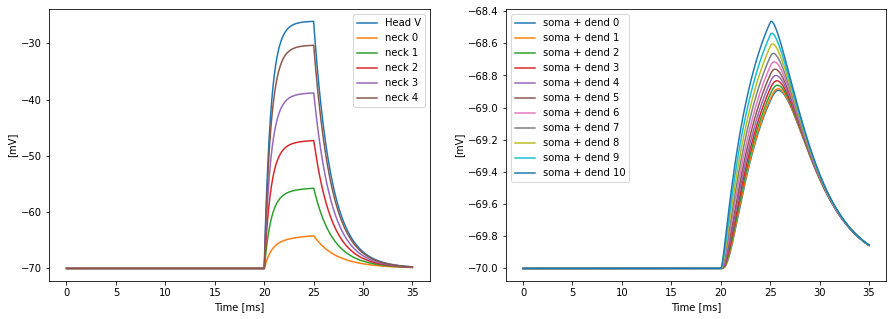

In [44]:
fig, axs = plt.subplots(1,2, figsize = (15,5))
axs[0].plot(M_spine_head.t/ms, M_spine_head.v[0]/mV, label = 'Head V')
for idx, item in enumerate(M_spine_neck):
    axs[0].plot(item.t/ms, item.v/mV, label = 'neck ' + str(idx))
axs[0].legend()
axs[0].set_xlabel('Time [ms]')
axs[0].set_ylabel('[mV]')

for idx, item in enumerate(M_soma):
    axs[1].plot(M_soma.t/ms, item.v/mV, label = 'soma + dend ' + str(idx))
axs[1].legend()
axs[1].set_xlabel('Time [ms]')
axs[1].set_ylabel('[mV]')


In [45]:
def EPSP(monitor):
    """returns EPSP in mV

    Args:
        monitor (State Monitor): the state monitor for the desired compartment

    Returns:
        float : EPSP
    """
    t = monitor.t/ms
    v = monitor.v/mV
    return np.max(v) - v[np.where(t<10)[0][-1]]

### Varying resistance

The length constant $\lambda = \sqrt{\frac{r_m}{r_i}}$ is inversely proportional to $R_i$. The effect on voltage decreases as resistance is increased.

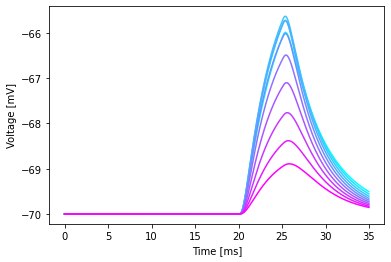

In [46]:
R_VALS = np.logspace(2, 4, 10)
EPSPs = np.zeros(len(R_VALS))

ax = plt.axes()
cmap = [matplotlib.cm.get_cmap('cool')(i) for i in np.linspace(0,1,len(R_VALS))]

ax.set_xlabel('Time [ms]')
ax.set_ylabel('Voltage [mV]')

for idx,r in enumerate(R_VALS):
    M_spine_head, M_spine_neck, M_soma = run_sim(default_params(I_stim = 10*pA, Ri_neck = r*ohm*cm))
    ax.plot(M_soma[0].t/ms, M_soma[0].v/mV, label = "R_neck = " + str(r), color = cmap[idx])
    EPSPs[idx] = EPSP(M_soma[0])

Text(0, 0.5, 'EPSP amplitude [mV]')

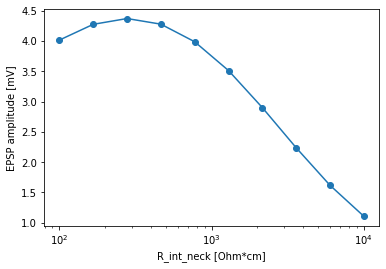

In [47]:
plt.semilogx(R_VALS, EPSPs)
plt.scatter(R_VALS, EPSPs)
plt.xlabel("R_int_neck [Ohm*cm]")
plt.ylabel("EPSP amplitude [mV]")

### Increasing gk

This should be equivalent to opening up the channels.

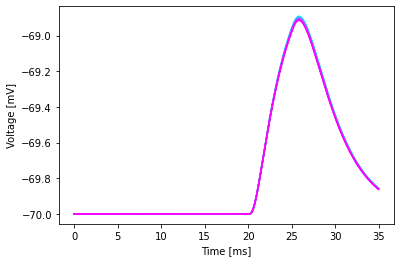

In [48]:
gk_vals = np.linspace(0.1, 10, 10)
EPSPs = np.zeros(len(gk_vals))

ax = plt.axes()
cmap = [matplotlib.cm.get_cmap('cool')(i) for i in np.linspace(0,1,len(gk_vals))]

ax.set_xlabel('Time [ms]')
ax.set_ylabel('Voltage [mV]')

for idx,gk in enumerate(gk_vals):
    M_spine_head, M_spine_neck, M_soma = run_sim(default_params(gK = gk * msiemens/cm**2))
    ax.plot(M_soma[0].t/ms, M_soma[0].v/mV, label = "gk = " + str(gk), color = cmap[idx])

    EPSPs[idx] = EPSP(M_soma[0])

Text(0, 0.5, 'EPSP amplitude [mV]')

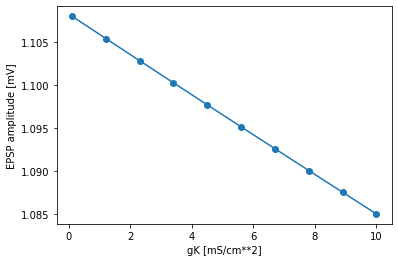

In [49]:
plt.plot(gk_vals, EPSPs)
plt.scatter(gk_vals, EPSPs)
plt.xlabel("gK [mS/cm**2]")
plt.ylabel("EPSP amplitude [mV]")

### Delta EPSP vs Resistance

Text(0, 0.5, 'deltaEPSP/EPSP')

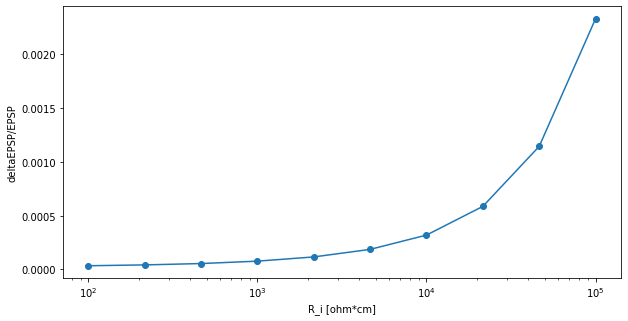

In [50]:
R_VALS = np.logspace(2, 5, 10)
deltaEPSP = np.zeros(len(R_VALS))

fig, axs = plt.subplots(figsize = (10, 5))

for idx,r in enumerate(R_VALS):
    M_spine_head_1, M_spine_neck_1, M_soma_1 = run_sim(default_params(Ri_neck = r*ohm*cm, gK = 0.5*siemens/meter**2))
    M_spine_head_2, M_spine_neck_2, M_soma_2 = run_sim(default_params(Ri_neck = r*ohm*cm, gK = 2*siemens/meter**2))
    deltaEPSP[idx] = (EPSP(M_soma_1[0]) - EPSP(M_soma_2[0]))/EPSP(M_soma_1[0])
    
axs.scatter(R_VALS, deltaEPSP)
axs.plot(R_VALS, deltaEPSP)
axs.set_xscale('log')
axs.set_xlabel('R_i [ohm*cm]')
axs.set_ylabel('deltaEPSP/EPSP')